In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import numpy as np
from scipy import ndimage
import cv2
from gc import collect
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn
import cv2
from sklearn.utils import shuffle

In [3]:
def get_labels(label_file):
    """lê a tabela com as informações dos pacientes e retorna uma matriz com o ID e as labels"""
    labels = pd.read_csv(label_file)
    cancer_labels = dict()

    for p in labels.index:
        cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

    return cancer_labels

In [4]:
def read_dataset(features_pathfile, csv_labels_pathfile, images_per_class):
  """
      A partir de um conjunto de numpy arrays salvos e do csv com as 
  labels, será montado o conjunto de dados para uso nos algoritmos com um 
  número máximo de features por classe. 
  ********(função com possível modificação no futuro)********
  """
  examples_per_class = [0, 0, 0, 0]

  pacients_ID = os.listdir(features_pathfile)
  labels_list = get_labels(csv_labels_pathfile)
  X, y = [], []
  for ID in pacients_ID:
    try:
        label = labels_list[ID[:-4]]
    except:
        continue
    if images_per_class != -1:
        if examples_per_class[np.argmax(label)] > images_per_class:
            continue

        examples_per_class[np.argmax(label)] += 1
        X.append(np.load(features_pathfile + '/' + ID))

        if len(y) == images_per_class*4:
            break
    else:
        X.append(np.load(features_pathfile + '/' + ID))

    y.append(label)

  return np.array(X), np.array(y)

In [5]:
def data_augmentation(X, y):
    new_images = []
    new_labels = []
    for x, label in zip(X, y):
        x = np.squeeze(x, -1)
        new_images.append(np.expand_dims(x, -1).astype('float16'))
        
        new_images.append(ndimage.rotate(np.expand_dims(x, -1).astype('float32'), angle=10, axes=(1, 0), reshape=False).astype('float16'))
        new_images.append(ndimage.rotate(np.expand_dims(x, -1).astype('float32'), angle=-10, axes=(1, 0), reshape=False).astype('float16'))
        
        x = cv2.flip(x, 1)
        new_images.append(np.expand_dims(x, -1).astype('float16'))
        new_images.append(ndimage.rotate(np.expand_dims(x, -1).astype('float32'), angle=10, axes=(1, 0), reshape=False).astype('float16'))
        new_images.append(ndimage.rotate(np.expand_dims(x, -1).astype('float32'), angle=-10, axes=(1, 0), reshape=False).astype('float16'))
        
        for _ in range(6):
            new_labels.append(label)
        
    return np.array(new_images), np.array(new_labels)

In [6]:
def separate_slices(img):
  slices = []

  for i in range(img.shape[-2]):
    slices.append(img[:,:,i])
  
  slices.append(np.mean(img, axis=-2))

  return slices

In [7]:
X, y = read_dataset('/content/drive/MyDrive/zap/240x320x10', '/content/drive/MyDrive/zap/arrays_gigantes/labels.csv', -1)


dataset_length = len(X)

X, y = shuffle(X, y, random_state=437843)

X_train, y_train = X[0:int(dataset_length*0.6)], y[0:int(dataset_length*0.6)]
X_val, y_val = X[int(dataset_length*0.6):int(dataset_length*0.8)], y[int(dataset_length*0.6):int(dataset_length*0.8)]
X_test, y_test = X[int(dataset_length*0.8):], y[int(dataset_length*0.8):]

In [8]:
X_train, y_train = data_augmentation(X_train, y_train)

In [9]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [10]:
#callback para salvar o modelo posteriormente
checkpoint_callback_accuracy = tf.keras.callbacks.ModelCheckpoint(filepath='./models/accuracy/',
                                                                  save_weights_only=True,
                                                                  monitor='val_categorical_accuracy',
                                                                  mode='max',
                                                                  save_best_only=True)

checkpoint_callback_precision = tf.keras.callbacks.ModelCheckpoint(filepath='./models/precision/',
                                                                   save_weights_only=True,
                                                                   monitor='val_precision',
                                                                   mode='max',
                                                                   save_best_only=True)

checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_auc',
                                                             mode='max',
                                                             save_best_only=True)

checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_auc_1',
                                                             mode='max',
                                                             save_best_only=True)

checkpoint_loss = tf.keras.callbacks.ModelCheckpoint(filepath='.models/models/loss/',
                                                     save_weights_only=True,
                                                     monitor='val_loss',
                                                     mode='min',
                                                     save_best_only=True)

In [11]:
class multi_VGG(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        self.hiddens1 = [tf.keras.layers.Conv2D(input_shape=(240, 320, 1), filters=64, kernel_size=(6,8), use_bias=True, 
                                                 padding='same', activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True,padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu",kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same',
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', strides=2, 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(3, 4))]
        
        self.hiddens2 = [tf.keras.layers.Conv2D(input_shape=(240, 320, 1), filters=64, kernel_size=(6,8), use_bias=True, 
                                                 padding='same', activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True,padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu",kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same',
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', strides=2, 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(3, 4))]
        
        self.hiddens3 = [tf.keras.layers.Conv2D(input_shape=(240, 320, 1), filters=64, kernel_size=(6,8), use_bias=True, 
                                                 padding='same', activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True,padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu",kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same',
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', strides=2, 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(3, 4))]
        
        self.hiddens4 = [tf.keras.layers.Conv2D(input_shape=(240, 320, 1), filters=64, kernel_size=(6,8), use_bias=True, 
                                                 padding='same', activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True,padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu",kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same',
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', strides=2, 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(3, 4))]
        
        self.hiddens5 = [tf.keras.layers.Conv2D(input_shape=(240, 320, 1), filters=64, kernel_size=(6,8), use_bias=True, 
                                                 padding='same', activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True,padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu",kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same',
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', strides=2, 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(3, 4))]
        
        self.hiddens6 = [tf.keras.layers.Conv2D(input_shape=(240, 320, 1), filters=64, kernel_size=(6,8), use_bias=True, 
                                                 padding='same', activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True,padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu",kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same',
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', strides=2, 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(3, 4))]
        
        self.hiddens7 = [tf.keras.layers.Conv2D(input_shape=(240, 320, 1), filters=64, kernel_size=(6,8), use_bias=True, 
                                                 padding='same', activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True,padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu",kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same',
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', strides=2, 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(3, 4))]
        
        self.hiddens8 = [tf.keras.layers.Conv2D(input_shape=(240, 320, 1), filters=64, kernel_size=(6,8), use_bias=True, 
                                                 padding='same', activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True,padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu",kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same',
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', strides=2, 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(3, 4))]
        
        self.hiddens9 = [tf.keras.layers.Conv2D(input_shape=(240, 320, 1), filters=64, kernel_size=(6,8), use_bias=True, 
                                                 padding='same', activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True,padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu",kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same',
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', strides=2, 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(3, 4))]
        
        self.hiddens10 = [tf.keras.layers.Conv2D(input_shape=(240, 320, 1), filters=64, kernel_size=(6,8), use_bias=True, 
                                                 padding='same', activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True,padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu",kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same',
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', strides=2, 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 4), use_bias=True, padding='same', 
                                                    activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D(pool_size=(3, 4))]
        
        self.dense_layers = [tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units=4096, activation='selu', kernel_initializer='lecun_normal'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(units=4096, activation='selu', kernel_initializer='lecun_normal'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(units=4096, activation='selu', kernel_initializer='lecun_normal'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dense(units=4, activation='softmax')]
        
    def call(self, inputs):
        input1 = tf.convert_to_tensor(inputs[:,:,:,0,0:])
        input2 = tf.convert_to_tensor(inputs[:,:,:,1,0:])
        input3 = tf.convert_to_tensor(inputs[:,:,:,2,0:])
        input4 = tf.convert_to_tensor(inputs[:,:,:,3,0:])
        input5 = tf.convert_to_tensor(inputs[:,:,:,4,0:])
        input6 = tf.convert_to_tensor(inputs[:,:,:,5,0:])
        input7 = tf.convert_to_tensor(inputs[:,:,:,6,0:])
        input8 = tf.convert_to_tensor(inputs[:,:,:,7,0:])
        input9 = tf.convert_to_tensor(inputs[:,:,:,8,0:])
        input10 = tf.convert_to_tensor(inputs[:,:,:,9,0:])
        
        output1 = self.hiddens1[0](input1)
        for layer in self.hiddens1[1:]:
            output1 = layer(output1)
            
        output2 = self.hiddens2[0](input2)
        for layer in self.hiddens2[1:]:
            output2 = layer(output2)        
            
        output3 = self.hiddens3[0](input3)
        for layer in self.hiddens3[1:]:
            output3 = layer(output3) 
            
        output4 = self.hiddens4[0](input4)
        for layer in self.hiddens4[1:]:
            output4 = layer(output4)
        
        output5 = self.hiddens5[0](input5)
        for layer in self.hiddens5[1:]:
            output5 = layer(output5) 
        
        output6 = self.hiddens6[0](input6)
        for layer in self.hiddens6[1:]:
            output6 = layer(output6) 
        
        output7 = self.hiddens7[0](input7)
        for layer in self.hiddens7[1:]:
            output7 = layer(output7) 
        
        output8 = self.hiddens8[0](input8)
        for layer in self.hiddens8[1:]:
            output8 = layer(output8) 
        
        output9 = self.hiddens9[0](input9)
        for layer in self.hiddens9[1:]:
            output9 = layer(output9) 
            
        output10 = self.hiddens10[0](input10)
        for layer in self.hiddens10[1:]:
            output10 = layer(output10) 
            
        concat = tf.keras.layers.concatenate([output1, output2, output3, output4, output5, output6, output7, output8, output9, output10])
        
        output = self.dense_layers[0](concat)
        for layer in self.dense_layers[1:]:
            output = layer(output)
            
        return output

In [12]:
multi_VGG_test = multi_VGG()

In [13]:
multi_VGG_test.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0015), 
                    loss='categorical_crossentropy', 
                    metrics=[tf.keras.metrics.CategoricalAccuracy(), 
                             tf.keras.metrics.Precision(),
                             tf.keras.metrics.AUC(multi_label=True, num_labels=4, label_weights=[1/0.3381294964028777, 1/0.2517985611510791, 1/0.2302158273381295, 1/0.17985611510791366]),
                             tf.keras.metrics.AUC(multi_label=True, num_labels=4)])

multi_VGG_test.fit(X_train,
                y_train,
                batch_size=8,
                epochs=50,
                shuffle=True,
                validation_data=(X_val, y_val),
                callbacks=[checkpoint_callback_accuracy, 
                           checkpoint_callback_precision, 
                           checkpoint_callback_auc1, 
                           checkpoint_callback_auc2,
                           checkpoint_loss],
                workers=1,
                use_multiprocessing=True)

Epoch 1/50
100/100 [==============================] - 251s 1s/step - loss: 5.2224 - categorical_accuracy: 0.2682 - precision: 0.2669 - auc: 0.5092 - auc_1: 0.5081 - val_loss: 315.0674 - val_categorical_accuracy: 0.3182 - val_precision: 0.3182 - val_auc: 0.5000 - val_auc_1: 0.5000
Epoch 2/50
100/100 [==============================] - 91s 915ms/step - loss: 2.4441 - categorical_accuracy: 0.3083 - precision: 0.3080 - auc: 0.5380 - auc_1: 0.5377 - val_loss: 5.2715 - val_categorical_accuracy: 0.2727 - val_precision: 0.2619 - val_auc: 0.5871 - val_auc_1: 0.5759
Epoch 3/50
100/100 [==============================] - 42s 418ms/step - loss: 2.4060 - categorical_accuracy: 0.2845 - precision: 0.2960 - auc: 0.5241 - auc_1: 0.5230 - val_loss: 7.5337 - val_categorical_accuracy: 0.0682 - val_precision: 0.0732 - val_auc: 0.4462 - val_auc_1: 0.4591
Epoch 4/50
100/100 [==============================] - 58s 578ms/step - loss: 2.1509 - categorical_accuracy: 0.3045 - precision: 0.3168 - auc: 0.5471 - auc_1:

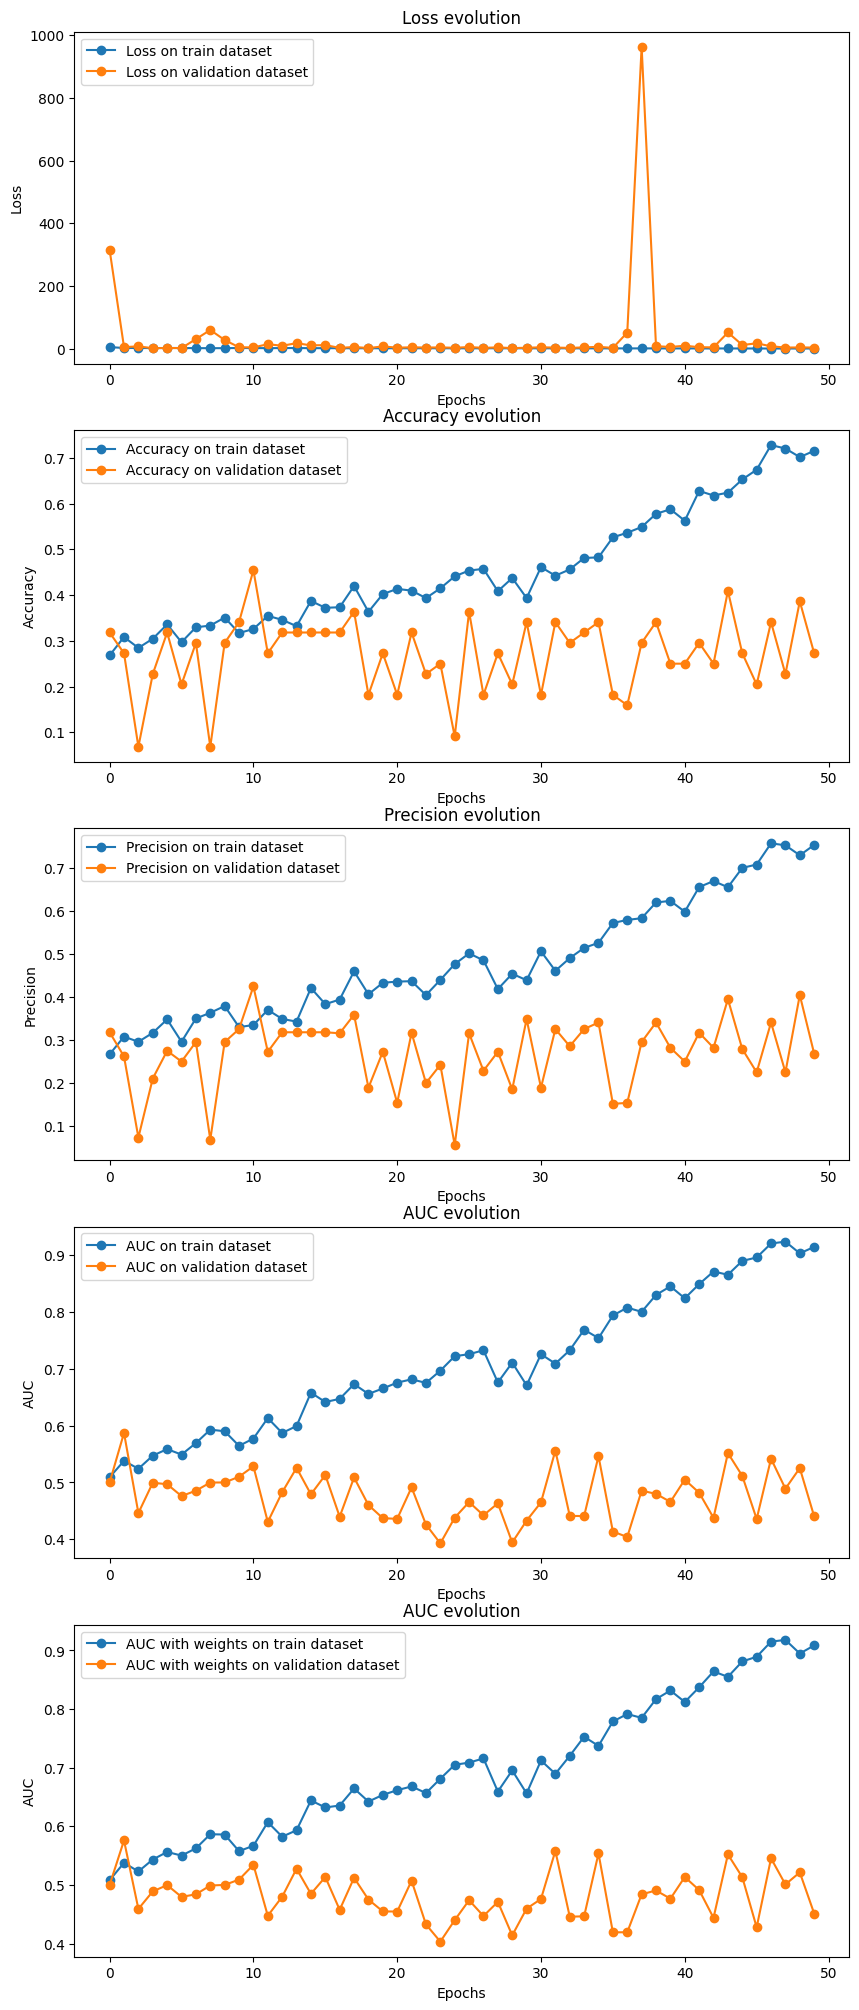

In [14]:
keys = list(multi_VGG_test.history.history.keys())

plt.figure(figsize=(10, 25))

plt.subplot(5, 1, 1)
plt.plot(multi_VGG_test.history.history[keys[0]], label='Training', marker='o')
plt.plot(multi_VGG_test.history.history[keys[5]], label='Validation', marker='o')
plt.title('Loss evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss on train dataset', 'Loss on validation dataset'])

plt.subplot(5, 1, 2)
plt.plot(multi_VGG_test.history.history[keys[1]], label='Training', marker='o')
plt.plot(multi_VGG_test.history.history[keys[6]], label='Validation', marker='o')
plt.title('Accuracy evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy on train dataset', 'Accuracy on validation dataset'])

plt.subplot(5, 1, 3)
plt.plot(multi_VGG_test.history.history[keys[2]], label='Training', marker='o')
plt.plot(multi_VGG_test.history.history[keys[7]], label='Validation', marker='o')
plt.title('Precision evolution')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(['Precision on train dataset', 'Precision on validation dataset'])

plt.subplot(5, 1, 4)
plt.plot(multi_VGG_test.history.history[keys[3]], label='Training', marker='o')
plt.plot(multi_VGG_test.history.history[keys[8]], label='Validation', marker='o')
plt.title('AUC evolution')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['AUC on train dataset', 'AUC on validation dataset'])

plt.subplot(5, 1, 5)
plt.plot(multi_VGG_test.history.history[keys[4]], label='Training', marker='o')
plt.plot(multi_VGG_test.history.history[keys[9]], label='Validation', marker='o')
plt.title('AUC evolution')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['AUC with weights on train dataset', 'AUC with weights on validation dataset'])

45/45 [==============================] - 3s 57ms/step - loss: 4.9878 - categorical_accuracy: 0.1778 - precision: 0.1628 - auc: 0.4442 - auc_1: 0.4442


<Axes: >

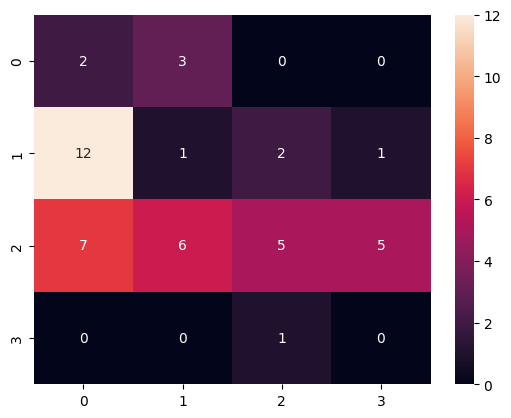

In [15]:
results_from_nn_test = []

for x in X_test:
  results_from_nn_test.append(multi_VGG_test.predict(np.array([x]), verbose=0))

multi_VGG_test.evaluate(X_test, y_test, batch_size=1)

confusion_matrix_test = [[0 for _ in range(4)] for _ in range(4)]

for pred, res in zip(results_from_nn_test, y_test):
  pred = np.argmax(pred[0])
  res = np.argmax(res)
  confusion_matrix_test[pred][res] += 1

seaborn.heatmap(confusion_matrix_test, annot=True)

45/45 [==============================] - 3s 57ms/step - loss: 5.7262 - categorical_accuracy: 0.3778 - precision: 0.3514 - auc: 0.4920 - auc_1: 0.4989


<Axes: >

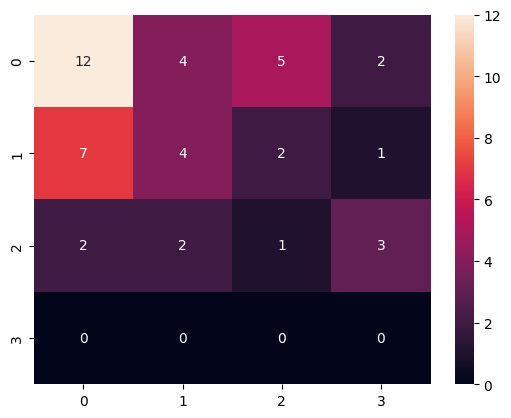

In [16]:
multi_VGG_test.load_weights('./models/accuracy/')

results_from_nn_test = []

for x in X_test:
  results_from_nn_test.append(multi_VGG_test.predict(np.array([x]), verbose=0))

multi_VGG_test.evaluate(X_test, y_test, batch_size=1)

confusion_matrix_test = [[0 for _ in range(4)] for _ in range(4)]

for pred, res in zip(results_from_nn_test, y_test):
  pred = np.argmax(pred[0])
  res = np.argmax(res)
  confusion_matrix_test[pred][res] += 1

seaborn.heatmap(confusion_matrix_test, annot=True)

45/45 [==============================] - 3s 57ms/step - loss: 5.7262 - categorical_accuracy: 0.3778 - precision: 0.3514 - auc: 0.4920 - auc_1: 0.4989


<Axes: >

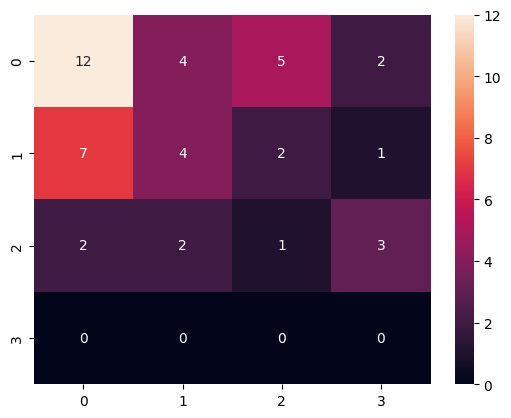

In [17]:
multi_VGG_test.load_weights('./models/precision/')

results_from_nn_test = []

for x in X_test:
  results_from_nn_test.append(multi_VGG_test.predict(np.array([x]), verbose=0))

multi_VGG_test.evaluate(X_test, y_test, batch_size=1)

confusion_matrix_test = [[0 for _ in range(4)] for _ in range(4)]

for pred, res in zip(results_from_nn_test, y_test):
  pred = np.argmax(pred[0])
  res = np.argmax(res)
  confusion_matrix_test[pred][res] += 1

seaborn.heatmap(confusion_matrix_test, annot=True)

45/45 [==============================] - 3s 57ms/step - loss: 7.5245 - categorical_accuracy: 0.1111 - precision: 0.1163 - auc: 0.4523 - auc_1: 0.4604


<Axes: >

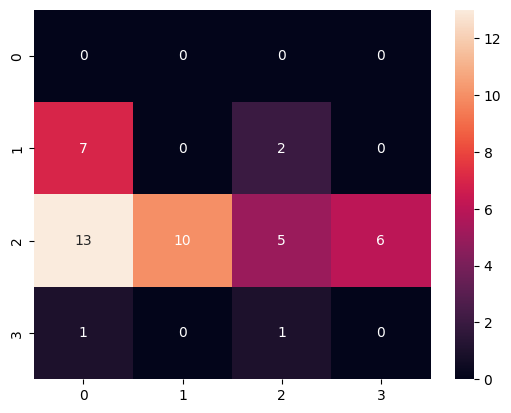

In [18]:
multi_VGG_test.load_weights('./models/auc1/')

results_from_nn_test = []

for x in X_test:
  results_from_nn_test.append(multi_VGG_test.predict(np.array([x]), verbose=0))

multi_VGG_test.evaluate(X_test, y_test, batch_size=1)

confusion_matrix_test = [[0 for _ in range(4)] for _ in range(4)]

for pred, res in zip(results_from_nn_test, y_test):
  pred = np.argmax(pred[0])
  res = np.argmax(res)
  confusion_matrix_test[pred][res] += 1

seaborn.heatmap(confusion_matrix_test, annot=True)

45/45 [==============================] - 3s 57ms/step - loss: 7.5245 - categorical_accuracy: 0.1111 - precision: 0.1163 - auc: 0.4523 - auc_1: 0.4604


<Axes: >

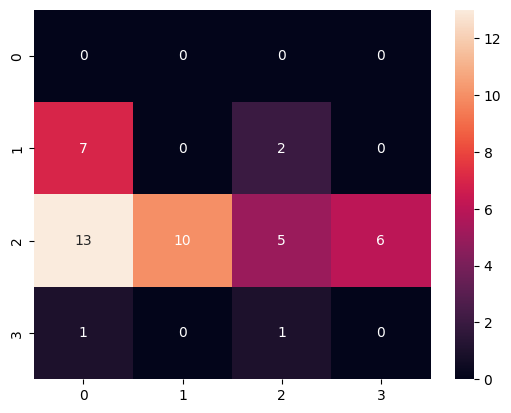

In [19]:
multi_VGG_test.load_weights('./models/auc2/')

results_from_nn_test = []

for x in X_test:
  results_from_nn_test.append(multi_VGG_test.predict(np.array([x]), verbose=0))

multi_VGG_test.evaluate(X_test, y_test, batch_size=1)

confusion_matrix_test = [[0 for _ in range(4)] for _ in range(4)]

for pred, res in zip(results_from_nn_test, y_test):
  pred = np.argmax(pred[0])
  res = np.argmax(res)
  confusion_matrix_test[pred][res] += 1

seaborn.heatmap(confusion_matrix_test, annot=True)

45/45 [==============================] - 3s 57ms/step - loss: 1.8082 - categorical_accuracy: 0.2222 - precision: 0.2857 - auc: 0.3599 - auc_1: 0.3614


<Axes: >

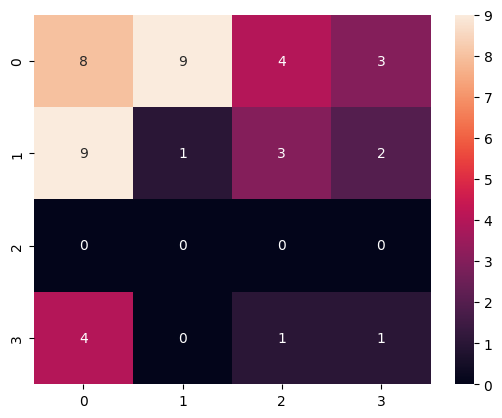

In [20]:
multi_VGG_test.load_weights('.models/models/loss/')

results_from_nn_test = []

for x in X_test:
  results_from_nn_test.append(multi_VGG_test.predict(np.array([x]), verbose=0))

multi_VGG_test.evaluate(X_test, y_test, batch_size=1)

confusion_matrix_test = [[0 for _ in range(4)] for _ in range(4)]

for pred, res in zip(results_from_nn_test, y_test):
  pred = np.argmax(pred[0])
  res = np.argmax(res)
  confusion_matrix_test[pred][res] += 1

seaborn.heatmap(confusion_matrix_test, annot=True)